# Import Required Packages

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import geopandas as gpd
from sklearn.model_selection import train_test_split
import missingno as msno

from pysal.lib.weights.contiguity import Queen

from pysal.explore.esda.moran import Moran_Local
from pysal.viz.splot.esda import plot_local_autocorrelation

from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from bokeh.plotting import figure, show
from bokeh.layouts import layout, column, row, widgetbox 
from bokeh.models import ColumnDataSource, Div
from bokeh.models.widgets import Slider, Select, TextInput, Panel, Tabs
from bokeh.models.glyphs import ImageURL
from bokeh.io import curdoc, output_file, show

from bokeh.palettes import Pastel2 as palette
from bokeh.models import LogColorMapper


# Create required functions

In [261]:

def calculate_percentages(df, column_list, divided_by): 
    for column in column_list: 
        new_col_name = column + '_per'
        df[new_col_name] = df[column]/df[divided_by]
    return df
        
        

In [262]:

def create_tract_lookup(df): 
    df['STATEFP10'] = df['STATEFP10'].astype('str')
    df['COUNTYFP10'] = df['COUNTYFP10'].astype('str')
    df['TRACTCE10'] = df['TRACTCE10'].astype('str')
    df['TractLookup'] = df['STATEFP10'] + df['COUNTYFP10'] + df['TRACTCE10']
    return df

# Read in the datasets, including HIV data and Charlotte OPen Data Portal Shape Files

In [263]:
df_hiv = pd.read_csv('./data/hiv-clt-zipcode.csv')

#zip_geo = pd.read_csv('./data/Zip_location.csv', dtype={'ZIP': 'str'})
#zip_geo['ZIP'] = [str.zfill(x,5) for x in zip_geo['ZIP']]
#data_NC = data_filtered[data_filtered['GEO_TTL'].str.contains(', NC')]

zip_geo = gpd.read_file('./data/cb_2017_us_zcta510_500k/cb_2017_us_zcta510_500k.shp')

census_blocks = gpd.read_file('C:/Users/renee/Desktop/Datasets/CLT_Data/Census_Block_Groups/Census_Block_Groups.shp')
ed_attain = gpd.read_file('C:/Users/renee/Desktop/Datasets/CLT_Data/Census_Educational_Attainment_Block_Groups/Census_Educational_Attainment_Block_Groups.shp')
emp_status = gpd.read_file('C:/Users/renee/Desktop/Datasets/CLT_Data/Census_Employment_Status_Block_Groups/Census_Employment_Status_Block_Groups.shp')
house_inc = gpd.read_file('C:/Users/renee/Desktop/Datasets/CLT_Data/Census_Household_Income_Block_Groups/Census_Household_Income_Block_Groups.shp')
house_val =  gpd.read_file('C:/Users/renee/Desktop/Datasets/CLT_Data/Census_Housing_Value_Block_Groups/Census_Housing_Value_Block_Groups.shp')
pop = gpd.read_file('C:/Users/renee/Desktop/Datasets/CLT_Data/Census_Population_Block_Groups/Census_Population_Block_Groups.shp')
poverty = gpd.read_file('C:/Users/renee/Desktop/Datasets/CLT_Data/Census_Poverty_Tracts/Census_Poverty_Tracts.shp')
med = gpd.read_file('C:/Users/renee/Desktop/Datasets/CLT_Data/Medical_Facility_Parcels/Medical_Facility_Parcels.shp')

In [264]:
tracts = pd.read_csv( 'C:/Users/renee/AnacondaProjects/HackCLT2019/data/TRACT_ZIP_122017.csv')

In [265]:
census_blocks.head()
census_blocks.to_csv('census.csv')

In [266]:
tracts.head()
tracts.to_csv('tracts.csv')

# Run to block to tract lookup to create new lookup ID column 

In [267]:

census_blocks = create_tract_lookup(census_blocks)
ed_attain = create_tract_lookup(ed_attain)
emp_status = create_tract_lookup(emp_status)
house_inc = create_tract_lookup(house_inc)
house_val= create_tract_lookup(house_val)
pop = create_tract_lookup(pop)
#med = create_tract_lookup(med)

# Decide what columns to keep for Analysis

In [268]:
##### Rename these columns becasue they are same name in different shape files with different values/meanings

house_inc.rename(columns={'Median_Hou': 'Median_Hou_Inc'}, inplace=True)

house_val.rename(columns={'Median_Hou': 'Median_Hou_Val'}, inplace=True)


In [269]:
#fill in any missing values with 0, meaning no reported cases
df_hiv.fillna(0)

df_hiv_keep = df_hiv.filter(like='rate', axis=1)


In [270]:

census_blocks_keep = census_blocks[['GEOID10','Population',  'AmerIn_Ala', 
       'NatHawaiia', 'Some_other', 'Two_or_mor', 'Housing_Un',
       'Occupied_H', 'Vacant_Hou', 'Occupancy_', 'Percent_Wh', 'Percent_Af',
       'Percent_As', 'Percent_Hi', 'Pop_SqMi', 'geometry', 'TractLookup']]


ed_attain_keep = ed_attain[['GEOID10','No_Diploma', 'High_Schoo', 'Some_colle', 'Associates', 'Bachelors_',
       'Masters_De', 'Doctorate_' ]]

emp_status_keep = emp_status[['GEOID10', 'In_labor_f', 'Civilian_l', 'Civilian_1', 'Civilian_2', 'Armed_forc',
       'Not_in_lab', 'Unemployme']]

house_inc_keep = house_inc[['GEOID10', 'Median_Hou_Inc','Total_Hous',
       'Less_than_', 'i10000_to_', 'i15000_to1', 'i20000_to_', 'i25000_to_',
       'i30000_to_', 'i35000_to_', 'i40000_to_', 'i45000_to_', 'i50000_to_',
       'i60000_to_', 'i75000_to_', 'i100000_to', 'i125000_to', 'i150000_to',
       'i200000_or',  'TotalFamil', 'FamiliesIn', 'FamilyPove']]


house_val_keep = house_val[['GEOID10', 'Median_Hou_Val', 'houses',
       'lessthan10', 'a10kto1499', 'a15kto1999', 'a20kto2499', 'a25kto2999',
       'a30kto3499', 'a35kto3999', 'a40kto4999', 'a50kto5999', 'a60kto6999',
       'a70kto7999', 'a80kto8999', 'a90kto9999', 'a100kto124', 'a125kto149',
       'a150kto174', 'a175kto199', 'a200kto249', 'a250kto299', 'a300kto399',
       'a400kto499', 'a500kto749', 'a750kto999', 'a1Mto14999', 'a1500000to',
       'a2MorMore', 'Units_with', 'MedianGros']]


pop_keep = pop[['GEOID10', 'Households',  'Vacancy_Ra', 'Pct_OwnerO', 'OwnerOccup', 'GroupQuart', 'Age0_17', 'Age18_34',
       'Age35_64', 'Age65andOv', 'OnePersonH', 'TwoPersonH', 'ThreePerso',
       'FourPerson', 'FivePerson', 'SixPersonH', 'SevenOrMor', 'SqMi',
       'Pop_2010', 'Pop_Change', 'MedianAge']]


In [271]:
df_hiv_keep['zip'] = df_hiv['zip']
#df_hiv_keep.head()

C:\Users\renee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Merge the CLT dataframes together

In [272]:
gdf1= pd.merge(census_blocks_keep, ed_attain_keep, on='GEOID10')
gdf2 = pd.merge(gdf1, emp_status_keep, on='GEOID10')
gdf3 = pd.merge(gdf2, house_inc_keep, on='GEOID10')
gdf4 = pd.merge(gdf3, house_val_keep, on='GEOID10')
gdf5 = pd.merge(gdf4, pop_keep, on='GEOID10')

print(gdf1.shape)
print(gdf2.shape)
print(gdf3.shape)

gdf_full = gpd.GeoDataFrame(gdf5, geometry='geometry')
gdf_full.to_csv('gdf_test.csv')

(555, 24)
(555, 31)
(555, 52)


In [273]:
#census_blocks.to_csv('censes_test.csv')

column_list = ['AmerIn_Ala', 'NatHawaiia', 'Some_other', 'Two_or_mor', 'Housing_Un','Occupied_H', 'Vacant_Hou','No_Diploma', 'High_Schoo', 'Some_colle', 'Associates', 'Bachelors_',
       'Masters_De', 'Doctorate_', 'In_labor_f', 'Civilian_l', 'Civilian_1', 'Civilian_2', 'Armed_forc',
       'Not_in_lab', 'Total_Hous',
       'Less_than_', 'i10000_to_', 'i15000_to1', 'i20000_to_', 'i25000_to_',
       'i30000_to_', 'i35000_to_', 'i40000_to_', 'i45000_to_', 'i50000_to_',
       'i60000_to_', 'i75000_to_', 'i100000_to', 'i125000_to', 'i150000_to',
       'i200000_or', 'Median_Hou_Inc', 'TotalFamil', 'FamiliesIn', 'Median_Hou_Val', 'houses',
       'lessthan10', 'a10kto1499', 'a15kto1999', 'a20kto2499', 'a25kto2999',
       'a30kto3499', 'a35kto3999', 'a40kto4999', 'a50kto5999', 'a60kto6999',
       'a70kto7999', 'a80kto8999', 'a90kto9999', 'a100kto124', 'a125kto149',
       'a150kto174', 'a175kto199', 'a200kto249', 'a250kto299', 'a300kto399',
       'a400kto499', 'a500kto749', 'a750kto999', 'a1Mto14999', 'a1500000to',
       'a2MorMore', 'Units_with', 'MedianGros', 'Households', 'Housing_Un', 
 'OwnerOccup', 'GroupQuart', 'Age0_17', 'Age18_34',
       'Age35_64', 'Age65andOv', 'OnePersonH', 'TwoPersonH', 'ThreePerso',
       'FourPerson', 'FivePerson', 'SixPersonH', 'SevenOrMor', 'SqMi',
       'Pop_2010', 'MedianAge']

# Calculate percentages per population at zipcode level to normalize the dependent variables

In [274]:
percent_df = calculate_percentages(gdf_full, column_list, 'Population')


In [275]:
percent_df_new = percent_df.drop(column_list, axis=1).copy()

In [276]:
percent_df_new.head()
percent_df_new.to_csv('percent.csv')


In [277]:
df_zip_geo = zip_geo[['ZCTA5CE10', 'GEOID10', 'geometry']]


# Rank the zip codes and divide into three groups (high, med, low) for rate of people with HIV. 

In [278]:
df_hiv_keep['rank'] = pd.qcut(df_hiv_keep['rate_ppl_with_hiv_per_100k'], 3, labels=False)

C:\Users\renee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [279]:
print(df_hiv_keep.dtypes)
print(df_zip_geo.dtypes)
df_hiv_keep['zip'] = df_hiv_keep['zip'].astype('str', copy=False)


rate_ppl_with_hiv_per_100k_13to24      float64
rate_ppl_with_hiv_per_100k_25to44        int64
rate_ppl_with_hiv_per_100k_45to59        int64
rate_ppl_with_hiv_per_100k_60plus      float64
rate_ppl_with_hiv_per_100k_asian       float64
rate_ppl_with_hiv_per_100k_black       float64
rate_ppl_with_hiv_per_100k               int64
rate_denominator                         int64
rate_ppl_with_hiv_per_100k_female      float64
rate_ppl_with_hiv_per_100k_hispanic    float64
rate_ppl_with_hiv_per_100k_male          int64
rate_ppl_with_hiv_per_100k_white         int64
zip                                      int64
rank                                     int64
dtype: object
ZCTA5CE10    object
GEOID10      object
geometry     object
dtype: object


C:\Users\renee\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [280]:
#hiv_zip = pd.merge(df_zip_geo, df_hiv_keep, left_on='ZCTA5CE10', right_on='zip')

In [281]:
print(hiv_zip.dtypes)
print(tracts.dtypes)
tracts['zip'] = tracts['zip'].astype('str')
tracts['tract'] = tracts['tract'].astype('str')

ZCTA5CE10                               object
GEOID10                                 object
geometry                                object
rate_ppl_with_hiv_per_100k_13to24      float64
rate_ppl_with_hiv_per_100k_25to44        int64
rate_ppl_with_hiv_per_100k_45to59        int64
rate_ppl_with_hiv_per_100k_60plus      float64
rate_ppl_with_hiv_per_100k_asian       float64
rate_ppl_with_hiv_per_100k_black       float64
rate_ppl_with_hiv_per_100k               int64
rate_denominator                         int64
rate_ppl_with_hiv_per_100k_female      float64
rate_ppl_with_hiv_per_100k_hispanic    float64
rate_ppl_with_hiv_per_100k_male          int64
rate_ppl_with_hiv_per_100k_white         int64
zip                                     object
rank                                     int64
dtype: object
tract          int64
zip            int64
res_ratio    float64
bus_ratio    float64
oth_ratio    float64
tot_ratio    float64
dtype: object


In [282]:
hiv_lookup = pd.merge(hiv_zip, tracts, left_on='ZCTA5CE10', right_on='zip', how='left')

hiv_lookup.to_csv('hiv_lookup.csv')
percent_df_new.to_csv('percent_df_new.csv')

In [283]:
df_final_full = pd.merge(hiv_lookup, percent_df_new, left_on='tract', right_on='TractLookup')

In [284]:
df_final_full.shape

(953, 125)

In [285]:
hiv_gdf = gpd.GeoDataFrame(hiv_lookup)


In [286]:
hiv_gdf.crs = med.crs

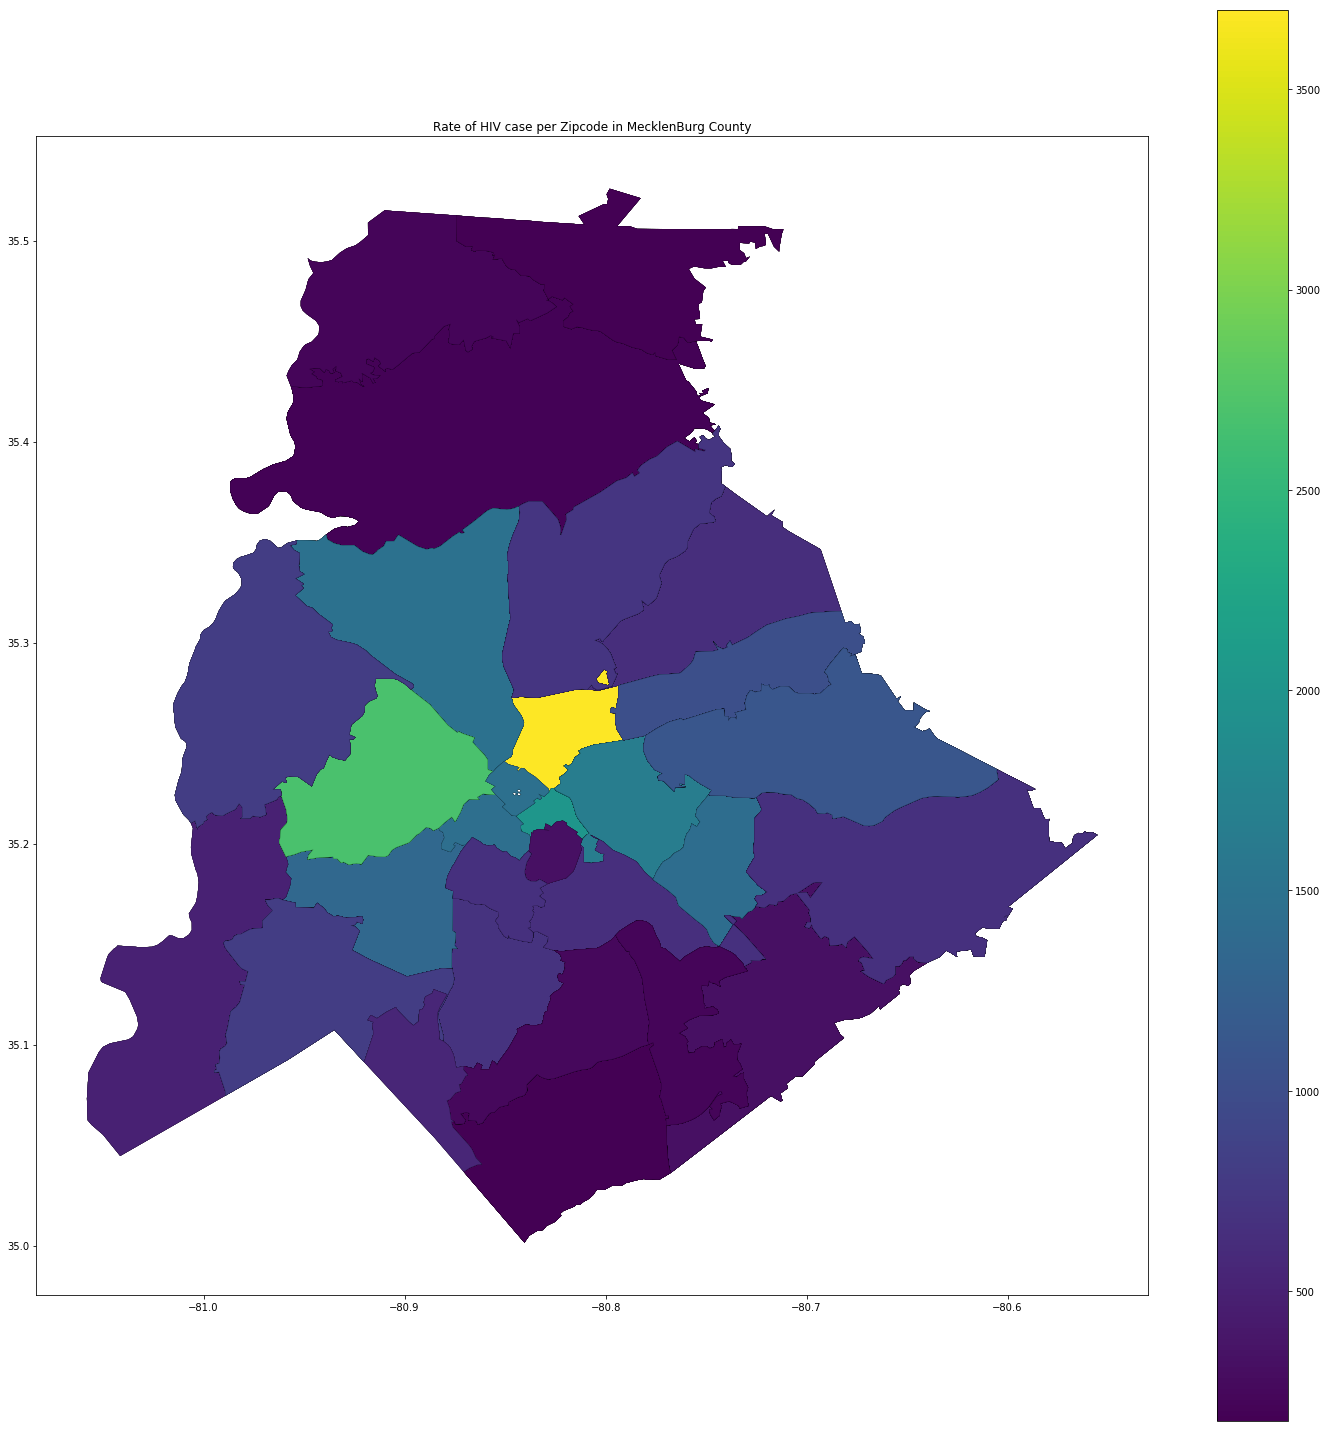

In [287]:

f, ax = plt.subplots(1, figsize=(20, 20))
base = hiv_gdf.plot(ax=ax, facecolor='blue', alpha=0.7, column='rate_ppl_with_hiv_per_100k', 
                     legend=True, linewidth=0.1, edgecolor='black')

#g = med.plot(ax=base, facecolor='white', alpha=0.7,legend=True, linewidth=0.1, edgecolor='black')
plt.title('Rate of HIV case per Zipcode in MecklenBurg County')
plt.tight_layout()

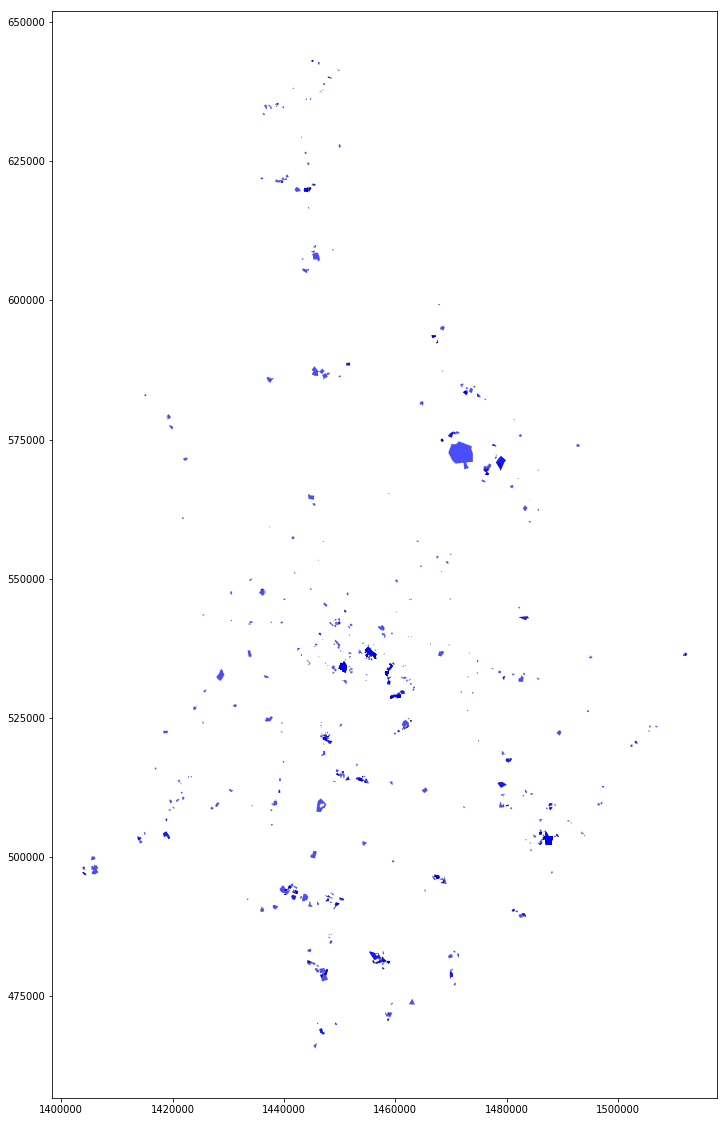

In [288]:

g, ax = plt.subplots(1, figsize=(20, 20))

med.plot(ax=ax, facecolor='blue', alpha=0.7,legend=True, linewidth=0.1, edgecolor='black')

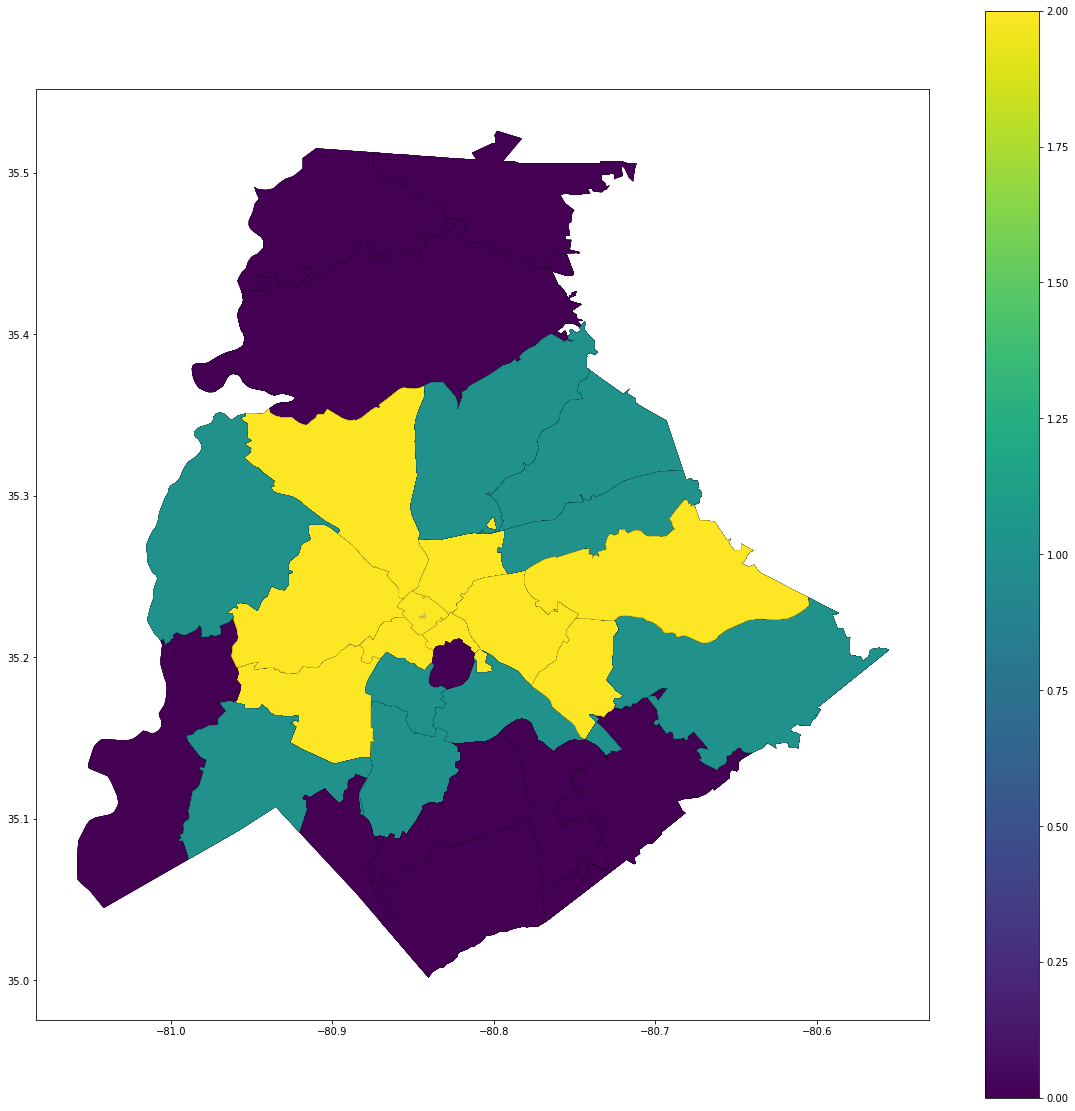

In [289]:
f, ax = plt.subplots(1, figsize=(20, 20))
base = hiv_gdf.plot(ax=ax, facecolor='blue', alpha=0.7, column='rank', 
                     legend=True, linewidth=0.1, edgecolor='black')

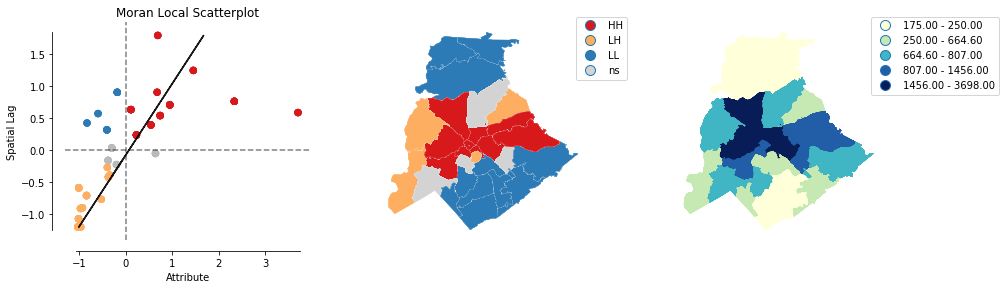

In [290]:
w = Queen.from_dataframe(hiv_gdf)
w.transform = 'r'
y = hiv_gdf['rate_ppl_with_hiv_per_100k'].values
moran_loc = Moran_Local(y, w)

auto_plot = plot_local_autocorrelation(moran_loc, hiv_gdf, y, p=0.05)
plt.savefig('./img.png')
    

In [291]:
X_data = df_final_full.iloc[:,19:125 ]
X_data['rank'] = df_final_full['rank']

print(X_data.shape)
print(y.shape)
X = X_data.drop(['GEOID10_y', 'TractLookup', 'geometry_y'], axis=1)
print(X_data.shape)

(953, 107)
(410,)
(953, 107)


In [293]:
with pd.option_context('mode.use_inf_as_null', True):
   new_X = X.dropna()
print(X.shape)


(953, 104)


In [294]:
print(new_X.shape)
y= new_X['rank']
new_X.drop(['rank'], axis=1, inplace=True)

(943, 104)


C:\Users\renee\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [295]:
# split the data intro train and test sets

X_train, X_test, y_train, y_test = train_test_split( new_X, y, test_size=0.33, random_state=42)

In [296]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(631, 103)
(312, 103)
(631,)
(312,)


# AdaBoost

In [297]:
from sklearn.metrics import confusion_matrix
def run_AdaBoost(X_train, y_train, X_test, y_test):  
    ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=30,
                           min_impurity_decrease = .0000001, random_state=0),
    n_estimators=5000,
    learning_rate=.1,
    algorithm="SAMME.R", 
    )

    ada_clf.fit(X_train, y_train)
    preds = ada_clf.predict(X_test)
    accuracy = (accuracy_score(preds, y_test))
    confusion = confusion_matrix(preds, y_test)
    model = ada_clf
    return (accuracy, confusion, model, preds)

In [298]:
#y = np.ravel(training_y)
accuracy_ada, confusion_ada, model_ada, preds_ada = run_AdaBoost(X_train, y_train, X_test, y_test)
print("accuracy: " + str(accuracy))
print(confusion)
    

accuracy: 0.5641025641025641
[[51 27 10]
 [29 58 25]
 [ 8 37 67]]


# GB Classifier

In [299]:
from sklearn.ensemble import GradientBoostingClassifier
def run_gradboost(X_train, y_train, X_test, y_test):
    gb = GradientBoostingClassifier(n_estimators=5000, learning_rate=.1, max_depth=30, 
                                    random_state=1234, max_features=.75).fit(X_train, y_train)
    preds = gb.predict(X_test)
    accuracy = (accuracy_score(preds, y_test))
    confusion = confusion_matrix(preds, y_test)
    model = gb
    return (accuracy, confusion, model, preds)

In [300]:
#y = np.ravel(training_y)
accuracy_gb, confusion_gb, model_gb, preds_gb = run_gradboost(X_train, y_train, X_test, y_test)
print("accuracy: " + str(accuracy_gb))
print(confusion_gb)

accuracy: 0.5961538461538461
[[57 24  4]
 [22 60 29]
 [ 9 38 69]]


# RandomForest

In [301]:
def run_randomforest(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=5000, max_depth=30, min_impurity_decrease = .000001, 
                                    random_state=1234, max_features=.75).fit(X_train, y_train)
    preds = rf.predict(X_test)
    accuracy = (accuracy_score(preds, y_test))
    confusion = confusion_matrix(preds, y_test)
    model = rf
    return (accuracy, confusion, model, preds)

In [302]:
accuracy_rf, confusion_rf, model_rf, preds_rf = run_randomforest(X_train, y_train, X_test, y_test)
print("accuracy: " + str(accuracy_rf))
print(confusion_rf)

accuracy: 0.6121794871794872
[[63 28  3]
 [21 55 26]
 [ 4 39 73]]


In [303]:
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Feature ranking:
1. feature 7 (0.136135)
2. feature 0 (0.048971)
3. feature 3 (0.038942)
4. feature 6 (0.038890)
5. feature 1 (0.036854)
6. feature 2 (0.036124)
7. feature 23 (0.027792)
8. feature 9 (0.021389)
9. feature 22 (0.020196)
10. feature 12 (0.019963)
11. feature 20 (0.018523)
12. feature 5 (0.017718)
13. feature 8 (0.015809)
14. feature 24 (0.014723)
15. feature 4 (0.013745)
16. feature 55 (0.012657)
17. feature 91 (0.012617)
18. feature 29 (0.012379)
19. feature 89 (0.012284)
20. feature 37 (0.011643)
21. feature 92 (0.011539)
22. feature 18 (0.011433)
23. feature 27 (0.010891)
24. feature 35 (0.010386)
25. feature 56 (0.009375)
26. feature 48 (0.009262)
27. feature 53 (0.009239)
28. feature 21 (0.008855)
29. feature 102 (0.008828)
30. feature 19 (0.008724)
31. feature 47 (0.008530)
32. feature 71 (0.008507)
33. feature 16 (0.008306)
34. feature 96 (0.007907)
35. feature 46 (0.007793)
36. feature 45 (0.007655)
37. feature 54 (0.007467)
38. feature 15 (0.007428)
39. feature 1

IndexError: index 103 is out of bounds for axis 0 with size 103

In [304]:
feature_names = X.columns


feat_ranks = dict(zip(feature_names, importances))
feat_ranks

{'Age0_17_per': 0.012284045327263396,
 'Age18_34_per': 0.006972466314538626,
 'Age35_64_per': 0.01261690113722751,
 'Age65andOv_per': 0.011539315605915614,
 'AmerIn_Ala_per': 0.00830604869260282,
 'Armed_forc_per': 0.0008828946765773205,
 'Associates_per': 0.006383453766105013,
 'Bachelors__per': 0.010890811761448722,
 'Civilian_1_per': 0.004641315778162191,
 'Civilian_2_per': 0.005287540136302225,
 'Civilian_l_per': 0.003949622382056602,
 'Doctorate__per': 0.012379201369500431,
 'FamiliesIn_per': 0.012656515242022312,
 'FamilyPove': 0.01996276183536037,
 'FivePerson_per': 0.004319551012620256,
 'FourPerson_per': 0.00790717466003914,
 'GroupQuart_per': 0.002007646918593451,
 'High_Schoo_per': 0.0147227684206718,
 'Households_per': 0.003553355438242626,
 'Housing_Un_per': 0.018523297995339017,
 'In_labor_f_per': 0.003831910920401621,
 'Less_than__per': 0.011642500595699065,
 'Masters_De_per': 0.00468294336007481,
 'MedianAge_per': 0.008828118594482893,
 'MedianGros_per': 0.0061669927348

# SVM

In [306]:
from sklearn.svm import SVC
def run_svm(X_train, y_train, X_test, y_test):
    svm = SVC(class_weight='balanced').fit(X_train, y_train)
    preds = svm.predict(X_test)
    accuracy = (accuracy_score(preds, y_test))
    confusion = confusion_matrix(preds, y_test)
    model = svm
    return (accuracy, confusion, model, preds)

In [307]:
y = np.ravel(y_train)
accuracy_svm, confusion_svm, model_svm, preds_svm = run_svm(X_train, y_train, X_test, y_test)
print("accuracy: " + str(accuracy))
print(confusion)

accuracy: 0.5641025641025641
[[51 27 10]
 [29 58 25]
 [ 8 37 67]]


# Create the voting model for final predictions

In [308]:
voting_preds = pd.DataFrame(columns=['ADABoost', 'GradientBoost', 'RandomForest', 'SVM'] )
voting_preds['ADABoost'] = preds_ada
voting_preds['GradientBoost'] = preds_gb
voting_preds['RandomForest'] = preds_rf
voting_preds['SVM'] = preds_svm

In [309]:
voting_preds

,ADABoost,GradientBoost,RandomForest,SVM
0,2,2,2,2
1,1,1,1,1
2,2,1,1,1
3,0,0,0,0
4,1,1,1,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,1
8,1,1,1,1
9,1,1,1,1


In [310]:
votes=  voting_preds.mode(axis=1)
voting_preds['Final Vote'] = votes.iloc[:,0]
voting_preds

,ADABoost,GradientBoost,RandomForest,SVM,Final Vote
0,2,2,2,2,2.0
1,1,1,1,1,1.0
2,2,1,1,1,1.0
3,0,0,0,0,0.0
4,1,1,1,1,1.0
5,1,1,1,1,1.0
6,1,1,1,1,1.0
7,1,1,1,1,1.0
8,1,1,1,1,1.0
9,1,1,1,1,1.0


# Cross validation

In [311]:
from sklearn.model_selection import cross_val_score

def cross_validate(model, _test, y_test):
    scores = cross_val_score(model, X_test, y_test, cv=5)
    print(scores)

In [312]:
cross_validate(model_svm, X_test, y_test)

[0.421875   0.40625    0.33870968 0.37704918 0.42622951]


In [313]:
from sklearn.svm import SVC

svm = SVC(class_weight='balanced').fit(X_train, y_train)
svm.score(X_test, y_test)

0.4423076923076923

In [319]:



# ************* From example https://automating-gis-processes.github.io/2017/lessons/L5/advanced-bokeh.html#id1 *********

def getPointCoords(row, geom, coord_type):
    """Calculates coordinates ('x' or 'y') of a Point geometry"""
    if coord_type == 'x':
        return row[geom].x
    elif coord_type == 'y':
        return row[geom].y
'''    
def getPolyCoords(geometry, coord_type):
    """ Returns Coordinates of Polygon using the Exterior of the Polygon."""
    ext = geometry.exterior
    return getXYCoords(ext, coord_type)  
'''
def getXYCoords(geometry, coord_type):
    """ Returns either x or y coordinates from  geometry coordinate sequence. Used with LineString and Polygon geometries."""
    if coord_type == 'x':
        return geometry.coords.xy[0]
    elif coord_type == 'y':
        return geometry.coords.xy[1]
    


def getPolyCoords(row, geom, coord_type):
    """Returns the coordinates ('x' or 'y') of edges of a Polygon exterior"""

    # Parse the exterior of the coordinate
    exterior = row[geom].exterior

    if coord_type == 'x':
        # Get the x coordinates of the exterior
        return list( exterior.coords.xy[0] )
    elif coord_type == 'y':
        # Get the y coordinates of the exterior
        return list( exterior.coords.xy[1] )
    
    
def getCoords(row, geom_col, coord_type):
    """
    Returns coordinates ('x' or 'y') of a geometry (Point, LineString or Polygon) as a list (if geometry is LineString or Polygon).
    Can handle also MultiGeometries.
    """
    # Get geometry
    geom = row[geom_col]

    # Check the geometry type
    gtype = geom.geom_type

    # "Normal" geometries
    # -------------------

    if gtype == "Point":
        return getPointCoords(geom, coord_type)
    elif gtype == "Polygon":
        return list( getPolyCoords(geom, coord_type) )
    else:
        return list( multiGeomHandler(geom, coord_type, gtype) )

    
def multiGeomHandler(multi_geometry, coord_type, geom_type):
    """
    Function for handling multi-geometries. Can be MultiPoint, MultiLineString or MultiPolygon.
    Returns a list of coordinates where all parts of Multi-geometries are merged into a single list.
    Individual geometries are separated with np.nan which is how Bokeh wants them.
    # Bokeh documentation regarding the Multi-geometry issues can be found here (it is an open issue)
    # https://github.com/bokeh/bokeh/issues/2321
    """

    for i, part in enumerate(multi_geometry):
        # On the first part of the Multi-geometry initialize the coord_array (np.array)
        if i == 0:
            if geom_type == "MultiPoint":
                coord_arrays = np.append(getPointCoords(part, coord_type), np.nan)
            elif geom_type == "MultiLineString":
                coord_arrays = np.append(getLineCoords(part, coord_type), np.nan)
            elif geom_type == "MultiPolygon":
                coord_arrays = np.append(getPolyCoords(part, coord_type), np.nan)
        else:
            if geom_type == "MultiPoint":
                coord_arrays = np.concatenate([coord_arrays, np.append(getPointCoords(part, coord_type), np.nan)])
            elif geom_type == "MultiLineString":
                coord_arrays = np.concatenate([coord_arrays, np.append(getLineCoords(part, coord_type), np.nan)])
            elif geom_type == "MultiPolygon":
                coord_arrays = np.concatenate([coord_arrays, np.append(getPolyCoords(part, coord_type), np.nan)])

    # Return the coordinates
    return coord_arrays    

# In[9]:


hiv_gdf['x'] = hiv_gdf.apply(getCoords, geom_col='geometry', coord_type='x', axis=1)
hiv_gdf['y'] = hiv_gdf.apply(getCoords, geom_col='geometry', coord_type='y', axis=1)

df_final_full['x'] = df_final_full.apply(getCoords, geom_col='geometry', coord_type='x', axis=1)
df_final_full['y'] = df_final_full.apply(getCoords, geom_col='geometry', coord_type='y', axis=1)


# In[10]:


p_df = hiv_gdf.drop(['geometry'], axis=1).copy()

psource = ColumnDataSource(p_df)
g_df = gdf_full.drop('geometry', axis=1).copy()
gsource = ColumnDataSource(g_df)


# In[11]:


from bokeh.palettes import PRGn as palette
from bokeh.models import ColorMapper


# In[70]:


from bokeh.models.glyphs import Circle, Patches
from bokeh.models.widgets import Div
#import holoviews as hv
#hv.notebook_extension('bokeh')

#hv.extension('bokeh')

color_mapper = LogColorMapper(palette=palette[7])

map_options = sorted(np.unique(hiv_gdf.columns))

p = figure(plot_height=700, plot_width=900, title="", toolbar_location=None)
#p2 = figure(x_range=(0,1), y_range=(0,1))

xdr = Range1d(start=-100, end=200)
ydr = Range1d(start=-100, end=200)

p2 = Plot(
    title=None, x_range=xdr, y_range=ydr, plot_width=1500, plot_height=500,
    h_symmetry=False, v_symmetry=False, min_border=0, toolbar_location=None)

w = Queen.from_dataframe(gdf_full)
w.transform = 'r'

#Create Input Control 
map_select = Select(title='Select Map Base', options=map_options, value='rate_ppl_with_hiv_per_100k')

def select_mapbase():
    base_val = map_select.value
    return base_val

def update(): 
    base_val = select_mapbase()

    #p.add_glpyh(gsource, map_patch)
    #p.circle(psource, daycare_point)
    #p, ax = plt.subplots(1, figsize=(20, 20))
   
    r2 = p.patches('x', 'y', source=psource, 
         fill_color={'field': base_val, 'transform': color_mapper}, 
         fill_alpha=1, line_color='black', line_width=0.1
         )
    #r1 = p.circle('x', 'y', source=psource, color='white', size=5)
    tt = (base_val, '@'+base_val)
    p.add_tools(HoverTool(renderers=[r2], tooltips=[tt]))
    #p.add_tools(HoverTool(renderers=[r1], tooltips=[()]))


# Add title
    p.title.text = "Mecklenburg County %s" %base_val

    
    
    color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker())
                         #label_standoff=2,border_line_color=None, location=(0,0))
   
    p.add_layout(color_bar, 'right')
    #li1 = LegendItem(label=color_mapper, renderers=[r2])
    #legend1 = Legend(items=[li1], location='top_right')
    #p1.add_layout(legend1)
    
    y = gdf_full[base_val].values

    moran_loc = Moran_Local(y, w)

    auto_plot = plot_local_autocorrelation(moran_loc, gdf_full, base_val, p=0.05)
    plt.savefig('./img.png')
    #C:/Users/renee/AnacondaProjects/Bokeh_Test
    
    url = "Bokeh_Test/static/img.png"
    #
    N = 1

    source = ColumnDataSource(dict(
        url = [url]*N,
        x1  = np.linspace(  0, 150, N),
        y1  = np.linspace(  0, 150, N),
        w1  = np.linspace( 10,  300, N),
        h1  = np.linspace( 10,  500, N),
    ))

    image1 = ImageURL(url="url", x="x1", y="y1", w=200, h=300, anchor="center")
    p2.add_glyph(source, image1)    

controls = [map_select]
for control in controls: 
    control.on_change('value', lambda attr, old, new: update())

#map_options.on_change('value', lambda attr, old, new: update())
inputs = column(*controls, sizing_mode = 'scale_width')

l1 = layout([[widgetbox(map_select), p]], sizing_mode='fixed')
l2 = layout([[p2]],sizing_mode='fixed')

tab1 = Panel(child=l1,title="This is Tab 1")
tab2 = Panel(child=l2,title="This is Tab 2")
tabs = Tabs(tabs=[ tab1, tab2 ]) 
#layout = sizing_mode = 'scale_width')

update()

#widgets = show(widgetbox(map_select, width=200))
curdoc().add_root(
    column(
        (
        row(widgetbox(map_select, width=200), p)), 
        row(p2) 
    )
)
        
curdoc().title = 'CLT Daycare Analysis'

#create a session
#session = push_session(curdoc())
#session.show()
#ssession.loop_until_closed()

#output_file("CLT_Analysis_Tooltips.html", title="interactive_map.py example")


# In[64]:


from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE) 


TypeError: ("getPolyCoords() missing 1 required positional argument: 'coord_type'", 'occurred at index 0')